In [1]:
# %%
# =============================================================================
#
# Pronositco usando un stacked MLP
#
# =============================================================================
import warnings

warnings.filterwarnings("ignore")

In [2]:
#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore


df_orig = functions.load_data()
df_orig.head()

,yt_true
date,
1946-01-01,890
1946-02-01,992
1946-03-01,979
1946-04-01,959
1946-05-01,1110


In [3]:
# %%

#
# Construcción de la matriz de regresores
#
df_orig = functions.make_lagged_ts(
    df=df_orig,
    p_max=13,
    y_column="yt_true",
    fmt="lagged_{}m",
)
df_orig.head()


,yt_true,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m
date,,,,,,,,,,,,,,
1946-01-01,890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-02-01,992,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-03-01,979,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-04-01,959,979.0,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-05-01,1110,959.0,979.0,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# %%
#
# Remoción de los valores faltantes
#
df_dropna = df_orig.dropna()
df_dropna.head()

,yt_true,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m
date,,,,,,,,,,,,,,
1947-02-01,1517,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0,890.0
1947-03-01,1707,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0
1947-04-01,1729,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0
1947-05-01,1788,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0
1947-06-01,2008,1788.0,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0


In [5]:
# %%
#
# División de los datos en entrenamiento y prueba
#
(
    X_complete,
    y_complete,
    X_train,
    y_train,
    X_test,
    y_test,
) = functions.train_test_split(
    df=df_dropna,
    x_columns=[f"lagged_{i}m" for i in range(1, 13)],
    y_column="yt_true",
)
X_complete.head()

,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m
date,,,,,,,,,,,,
1947-02-01,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0
1947-03-01,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0
1947-04-01,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0
1947-05-01,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0
1947-06-01,1788.0,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0


In [6]:
# %%
#
# Pronostico usando una red neuronal tipo MLP
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import MinMaxScaler  #  type: ignore
from sklearn.compose import TransformedTargetRegressor  #  type: ignore
from sklearn.neural_network import MLPRegressor  #  type: ignore


# Crea un pipeline para automatizar la creacion de un modelo
def make_pipeline_from_model(model):
    """Create a pipeline."""
    return Pipeline(
        [
            (
                "scaler",
                MinMaxScaler(),
            ),
            (
                "regressor",
                TransformedTargetRegressor(
                    regressor=model,
                    transformer=MinMaxScaler(),
                ),
            ),
        ]
    )

In [7]:
# %%
#
# Entrenamiento y pronostico del Modelo 0
#
hidden = 8

pipeline_0 = make_pipeline_from_model(
    model=MLPRegressor(
        hidden_layer_sizes=(hidden,),
        activation="logistic",
        learning_rate="adaptive",
        momentum=0.01,
        learning_rate_init=0.2,
        max_iter=10000,
        random_state=123456,
    )
)

pipeline_0.fit(X_train, y_train)

X_train_stacked = X_train.copy()
X_train_stacked["forecast_pipeline_0"] = pipeline_0.predict(X_train)

X_complete_stacked = X_complete.copy()
X_complete_stacked["forecast_pipeline_0"] = pipeline_0.predict(X_complete)

X_complete_stacked

,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,forecast_pipeline_0
date,,,,,,,,,,,,,
1947-02-01,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0,1260.828758
1947-03-01,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,1360.020367
1947-04-01,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,1434.927683
1947-05-01,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,1488.115980
1947-06-01,1788.0,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1665.903380
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966-08-01,5080.0,4798.0,4858.0,4734.0,4251.0,4140.0,4158.0,4573.0,4824.0,5142.0,6345.0,6481.0,5341.994598
1966-09-01,6905.0,5080.0,4798.0,4858.0,4734.0,4251.0,4140.0,4158.0,4573.0,4824.0,5142.0,6345.0,5454.659627
1966-10-01,5504.0,6905.0,5080.0,4798.0,4858.0,4734.0,4251.0,4140.0,4158.0,4573.0,4824.0,5142.0,5122.699353


In [8]:
# %%
#
# Entrenamiento y pronostico del Modelo 1
#
hidden = 8

pipeline_1 = make_pipeline_from_model(
    model=MLPRegressor(
        hidden_layer_sizes=(hidden,),
        activation="logistic",
        learning_rate="adaptive",
        momentum=0.01,
        learning_rate_init=0.2,
        max_iter=10000,
        random_state=12345,
    )
)

pipeline_1.fit(X_train_stacked, y_train)


df_dropna[f"yt_pred_stacked_mlp"] = pipeline_1.predict(X_complete_stacked)

df_dropna

,yt_true,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m,yt_pred_stacked_mlp
date,,,,,,,,,,,,,,,
1947-02-01,1517,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0,890.0,1205.909177
1947-03-01,1707,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0,1282.332378
1947-04-01,1729,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,1273.433293
1947-05-01,1788,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,1335.601747
1947-06-01,2008,1788.0,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,1497.369716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966-08-01,6905,5080.0,4798.0,4858.0,4734.0,4251.0,4140.0,4158.0,4573.0,4824.0,5142.0,6345.0,6481.0,4594.0,5000.383182
1966-09-01,5504,6905.0,5080.0,4798.0,4858.0,4734.0,4251.0,4140.0,4158.0,4573.0,4824.0,5142.0,6345.0,6481.0,5146.080202
1966-10-01,5457,5504.0,6905.0,5080.0,4798.0,4858.0,4734.0,4251.0,4140.0,4158.0,4573.0,4824.0,5142.0,6345.0,4798.048668


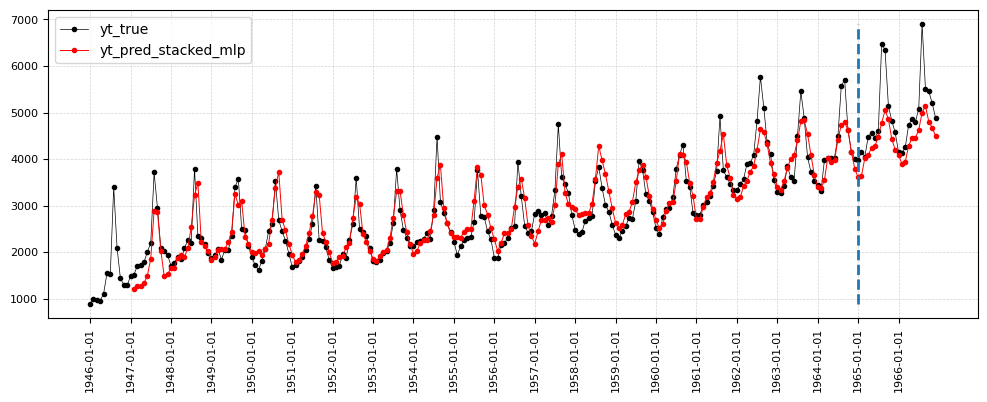

In [9]:
# %%
#
# Gráfica de los pronósticos
#
df_orig.loc[df_dropna.index, f"yt_pred_stacked_mlp"] = df_dropna[f"yt_pred_stacked_mlp"]

functions.plot_time_series(df=df_orig, yt_col="yt_true")


In [10]:
# %%
#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)

In [11]:
# %
#
# Métricas de error
#
metrics = functions.compute_evaluation_metrics(df_orig.dropna())
functions.save_metrics(metrics)
metrics

,Metrics,yt_pred_stacked_mlp
0,MSE Train,115875.97
1,MSE Test,462726.38
2,MAE Train,247.23
3,MAE Test,502.36
